# Train model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from load_qm9 import *
from display_mol import *

#load dataset
ds = qm9_load_torch()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:1


In [3]:
qm9_to_torch()

Using existing archive: ./data/QM9/qm9.tar.bz2
Parsed 133800/133885 molecules
Saved torch list to ./data/QM9/qm9_torch.pt


## data management and preprocessing

### Moldecule dataloader for trainning in batchs of equal size

In [2]:
ATOM_TYPES = [1, 6, 7, 8, 9]
MAX_SIZE = 30 # max number of atoms per molecules


class MoleculeDataset:
    def __init__(self, dataset):
        self.ds = dataset
        self.N = len(dataset)
        self.M_pdf = np.zeros(MAX_SIZE, dtype=np.int32)
        self.molecules_by_size = {i: [] for i in range(MAX_SIZE)}
        
        self._index_molecules()
        
        print(f"Dataset chargé : {self.N} molécules")
        print(f"Distribution des tailles : {self.M_pdf}")
    

    def _index_molecules(self):
        for idx, example in enumerate(self.ds):
            n_atoms = example[1].shape[0]
            self.M_pdf[n_atoms] += 1
            self.molecules_by_size[n_atoms].append(idx)
    
    
    def get_batch(self, batch_size): 
        """
        return generator that give infinite patchs with molecules of equal sizes
        """ 
        valid_sizes = [M for M in range(MAX_SIZE) if self.M_pdf[M] >= batch_size]

        valid_probs = np.array([self.M_pdf[M] for M in valid_sizes])
        valid_probs = valid_probs / valid_probs.sum() 
        
        while True:
            M = np.random.choice(valid_sizes, p=valid_probs)
            
            available_indices = self.molecules_by_size[M]
            
            selected_indices = np.random.choice( # shuffle
                    available_indices, 
                    size=batch_size, 
                    replace=False
                )
            
            batch = [self.ds[idx] for idx in selected_indices]
            
            yield self._collate_batch(batch)
    
    def _collate_batch(self, batch):
        """
        Combine une liste de molécules en un batch.
        """
        x = torch.stack([mol[0] for mol in batch], dim=0)
        y = torch.stack([mol[1] for mol in batch], dim=0)
        q = torch.stack([mol[2] for mol in batch], dim=0)
        
        return [x, y, q]
    
    def get_epoch_batches(self, batch_size):
        """
        Génère des batches pour une époque complète.
        Chaque molécule apparaît exactement une fois par époque.
        """
        all_batches = []
        
        for M in range(MAX_SIZE):
            if self.M_pdf[M] == 0:
                continue
            
            indices = self.molecules_by_size[M].copy()
            
            np.random.shuffle(indices)
            
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i + batch_size]
                if len(batch_indices) == batch_size:
                    batch = [self.molecules_list[idx] for idx in batch_indices]
                    all_batches.append(batch)
        
        np.random.shuffle(all_batches)
        
        for batch in all_batches:
            yield self._collate_batch(batch)
    

molecules = MoleculeDataset(ds) # ~1min30


Dataset chargé : 10 molécules
Distribution des tailles : [0 0 0 2 3 1 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [4]:


# Génération infinie de batches (pour l'entraînement)
batch_gen = molecules.get_batch(batch_size=2)

for i in range(5):
    batch = next(batch_gen)
    print([i.shape for i in batch])


[torch.Size([2, 4, 3]), torch.Size([2, 4]), torch.Size([2, 4])]
[torch.Size([2, 3, 3]), torch.Size([2, 3]), torch.Size([2, 3])]
[torch.Size([2, 6, 3]), torch.Size([2, 6]), torch.Size([2, 6])]
[torch.Size([2, 3, 3]), torch.Size([2, 3]), torch.Size([2, 3])]
[torch.Size([2, 3, 3]), torch.Size([2, 3]), torch.Size([2, 3])]


### one hot encoding for the molecule shape

In [5]:
def one_hot_encode(batch):
    x = batch[0]
    x -= torch.mean(x, axis=1)[:, None, :]
    e = batch[1]
    q = batch[2]
    
    max_atom_type = max(ATOM_TYPES) + 1
    lookup = torch.full((max_atom_type,), -1, dtype=torch.long)
    
    for idx, atom_type in enumerate(ATOM_TYPES):
        lookup[atom_type] = idx
    
    y_indices = lookup[e]
    
    assert (y_indices >= 0).all(), "Types d'atomes inconnus détectés!"
    
    
    e = torch.nn.functional.one_hot(y_indices, num_classes=len(ATOM_TYPES)).float()
    
    return [x, e, q]

def one_hot_decode(batch):
    x = batch[0].clone().detach()
    e_onehot = batch[1].clone().detach()
    q = batch[2].clone().detach()
    
    e_indices = torch.argmax(e_onehot, dim=-1)  # (batch_size, n_atoms)
    atom_types_tensor = torch.tensor(ATOM_TYPES, dtype=torch.long)
    e = atom_types_tensor[e_indices]
    
    return [x, e, q]



def one_hot_decode_stochastic(batch, temperature=1.0):
    x = batch[0].clone().detach()
    e_soft = batch[1].clone().detach()
    q = batch[2].clone().detach()
    
    # Option 2: Sampling selon les probabilités (stochastic)
    e_probs = torch.nn.functional.softmax(e_soft / temperature, dim=-1)
    e_indices = torch.multinomial(
        e_probs.view(-1, e_probs.size(-1)), 
        num_samples=1
    ).view(e_probs.shape[:-1])
    
    atom_types_tensor = torch.tensor(ATOM_TYPES, dtype=torch.long)
    e = atom_types_tensor[e_indices]
    
    return [x, e, q]
    

mol = one_hot_encode(next(batch_gen))   
print([e.shape for e in mol])
print([e.shape for e in one_hot_decode(mol)])

[torch.Size([2, 3, 3]), torch.Size([2, 3, 5]), torch.Size([2, 3])]
[torch.Size([2, 3, 3]), torch.Size([2, 3]), torch.Size([2, 3])]


## Model

In [132]:
class UltraMagaDiffusion(torch.nn.Module):
    def __init__(self):
        super(UltraMagaDiffusion, self).__init__()
        self.T = 10
        s = 1e-5
        self.alpha = [(1-2*s)*(1 - (t/self.T))+s for t in range(self.T+1)]
        self.omega = [1-alpha**2 for alpha in self.alpha]
        self.L = 6
        self.lr = 1e-4
        self.num_class = len(ATOM_TYPES)

        self.init_weight()
    
    def init_weight(self):
        self.phi_e = torch.nn.ModuleList()
        self.phi_inf = torch.nn.ModuleList()
        self.phi_x = torch.nn.ModuleList()
        self.phi_h = torch.nn.ModuleList()

        nf = self.num_class + 2  # +2 for atom charge and t/T

        for l in range(self.L):
            self.phi_e.append(torch.nn.Sequential(
                torch.nn.Linear(nf * 2 + 2, nf), 
                torch.nn.SiLU(),
                torch.nn.Linear(nf, nf),
                torch.nn.SiLU(),
            ))

            self.phi_inf.append(torch.nn.Sequential(
                torch.nn.Linear(nf, 1),
                torch.nn.Sigmoid(),
            ))

            self.phi_x.append(torch.nn.Sequential(
                torch.nn.Linear(nf * 2 + 2, nf),
                torch.nn.SiLU(),
                torch.nn.Linear(nf, nf),
                torch.nn.SiLU(),
                torch.nn.Linear(nf, 1),
            ))

            self.phi_h.append(torch.nn.Sequential(
                torch.nn.Linear(nf * 2, nf),
                torch.nn.SiLU(),
                torch.nn.Linear(nf, nf),
            ))
        
    
    def forward(self, mols, t):
        (x, e, q) = mols 
        h = torch.cat([e, q[:, :, None], torch.ones_like(q)[:, :, None]*t[:, :, None]/self.T], dim=-1)
        x0 = x.clone()
        N = h.shape[1]
        diff = x[:, :, None, :] - x[:, None, :, :]   # (B, N, N, 3)
        a_ij = torch.sqrt(torch.sum(diff ** 2, dim=-1))[:, :, :, None]  # (B, N, N, 1)
        for l in range(self.L):
            diff = x[:, :, None, :] - x[:, None, :, :]   # (B, N, N, 3)
            d_ij = torch.sqrt(torch.clamp(torch.sum(diff ** 2, dim=-1), min=1e-9))[:, :, :, None]  # (B, N, N, 1) distance squared matrix
        
            
            # compute m_ij
            h_i = h[:, :, None, :].expand(-1, N, N, -1)  # (B, N, N, d)
            h_j = h[:, None, :, :].expand(-1, N, N, -1)  # (B, N, N, d)

            features = torch.cat([h_i, h_j, d_ij, a_ij], dim=-1)  # (B, N, N, 2d+2)
            m_ij = self.phi_e[l](features)  # (B, N, N, d)

            # compute e_ij
            e_ij = self.phi_inf[l](m_ij) # (B, N, N, 1)

            # update x
            weights = self.phi_x[l](features) * diff / (d_ij + 1.0)  # (B, N, N, 3)
            x = x + weights.sum(dim=2)                          # (B, N, 3)
            

            # update h
            mask = ~torch.eye(N, dtype=bool, device=device)[None, :, :, None]  # (1, N, N, 1)
            agg = (e_ij * mask * m_ij).sum(dim=2)   # (B, N, d)
            h = h + self.phi_h[l](torch.cat([h, agg], dim=-1))   # (B, N, d)
    
        x = x - x0 # (B, N, 3)
        x = x - torch.mean(x, axis=1)[:, None, :] # (B, 1, 3)
        e, q = h[:, :, :self.num_class], h[:, :, self.num_class]
        return (x, e, q)
    

    def training_step(self, batch, optimizer):
        self.train()
        optimizer.zero_grad()

        x, e, q = batch
        B = x.shape[0]

        t = torch.randint(1, self.T + 1, (B, 1), device=device).float() # Random timestep per batch
        eps_x = torch.randn_like(x, device=device) # (B, N, 3)
        eps_e = torch.randn_like(e, device=device) # (B, N, D)
        eps_q = torch.randn_like(q, device=device) # (B, N)

        # Diffusion step: add noise to x0
        alpha_t = torch.tensor(self.alpha)[t.long()].view(B, 1, 1)
        omega_t = torch.sqrt(torch.tensor(self.omega))[t.long()].view(B, 1, 1)
        x_t = alpha_t * x + omega_t * eps_x
        e_t = alpha_t * e + omega_t * eps_e
        q_t = alpha_t.squeeze(-1) * q + omega_t.squeeze(-1) * eps_q

        # Predict denoised offset (model learns to predict ε)
        eps_x_pred, eps_e_pred, eps_q_pred = self.forward((x_t, e_t, q_t), t)
        
        # Reconstruction loss (denoising loss)
        loss_x = torch.nn.functional.mse_loss(eps_x_pred, eps_x)
        loss_e = torch.nn.functional.mse_loss(eps_e_pred, eps_e)
        loss_q = torch.nn.functional.mse_loss(eps_q_pred, eps_q)

        loss = loss_x + 0.25 * loss_e + 0.1 * loss_q # coef from the paper
        loss.backward()
        #print("====3debug :", torch.max(loss))
        optimizer.step()
        #print("====3debug :", torch.max(self.phi_x[0][0].weight))

        return {
            'loss': loss.detach().cpu().item(),
            'loss_x': loss_x.detach().cpu().item(),
            'loss_e': loss_e.detach().cpu().item(),
            'loss_q': loss_q.detach().cpu().item(),
        }


    @torch.no_grad()
    def sample(self, batch_size, N):
        self.eval()

        # Initialize x_T from Gaussian noise
        x = torch.randn(batch_size, N, 3, device=device)
        e = torch.randn(batch_size, N, self.num_class, device=device)
        q = torch.randn(batch_size, N, device=device)

        for t in reversed(range(1, self.T + 1)):
            t_tensor = torch.full((batch_size, 1), t, device=device).float()
            dx, de, dq = self.forward((x, e, q), t_tensor)

            # Compute coefficients
            alpha_t = torch.tensor(self.alpha[t], device=device).view(1, 1, 1)
            omega_t = torch.tensor(self.omega[t], device=device).view(1, 1, 1)
            alpha_s = torch.tensor(self.alpha[t-1], device=device).view(1, 1, 1)
            omega_s = torch.tensor(self.omega[t-1], device=device).view(1, 1, 1)

            alpha_ts = alpha_t/alpha_s
            omega_ts = omega_t - alpha_ts**2 * omega_s
            omega_t_s = torch.sqrt(omega_ts * omega_s / omega_t)
            # Reverse diffusion step
            eps_x = torch.randn_like(x, device=device) if t > 1 else 0.0
            eps_e = torch.randn_like(e, device=device) if t > 1 else 0.0
            eps_q = torch.randn_like(q, device=device) if t > 1 else 0.0
            x = x / alpha_s - omega_ts/(alpha_ts*torch.sqrt(omega_t)) * dx + omega_t_s * eps_x
            e = e / alpha_s - omega_ts/(alpha_ts*torch.sqrt(omega_t)) * de + omega_t_s * eps_e
            q = q / alpha_s.squeeze(-1) - (omega_ts/(alpha_ts*torch.sqrt(omega_t))).squeeze(-1) * dq + omega_t_s.squeeze(-1) * eps_q
        return x, e, q




model = UltraMagaDiffusion().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=model.lr)
batch_gen = molecules.get_batch(batch_size=8)
#torch.autograd.set_detect_anomaly(True)
max_iter = 1000
loss = []
for i in range(max_iter):
    batch = one_hot_encode(next(batch_gen))
    batch = [v.to(device) for v in batch]
    logs = model.training_step(batch, optimizer)
    print(f"\r{i+1}/{max_iter}", end="")
    if i % 50 == 0: 
        print(logs)
    loss += [logs['loss']]

# Sampling
#x_gen, e_gen, q_gen = model.sample(batch_size=8, N=9)


1/1000{'loss': 2.187464714050293, 'loss_x': 2.011521577835083, 'loss_e': 0.42326468229293823, 'loss_q': 0.7012690305709839}
51/1000{'loss': 1.0695466995239258, 'loss_x': 0.9181101322174072, 'loss_e': 0.41534194350242615, 'loss_q': 0.47601088881492615}
101/1000{'loss': 1.2479424476623535, 'loss_x': 1.1175674200057983, 'loss_e': 0.3816099762916565, 'loss_q': 0.34972572326660156}
151/1000{'loss': 1.0330110788345337, 'loss_x': 0.9324681758880615, 'loss_e': 0.2893443703651428, 'loss_q': 0.28206878900527954}
201/1000{'loss': 0.9000480771064758, 'loss_x': 0.8125001788139343, 'loss_e': 0.26353973150253296, 'loss_q': 0.2166295200586319}
251/1000{'loss': 0.5610108375549316, 'loss_x': 0.4943680167198181, 'loss_e': 0.2174888402223587, 'loss_q': 0.12270641326904297}
301/1000{'loss': 0.7175040245056152, 'loss_x': 0.6488479971885681, 'loss_e': 0.2145121544599533, 'loss_q': 0.15028016269207}
351/1000{'loss': 0.6692715287208557, 'loss_x': 0.5955159664154053, 'loss_e': 0.24237897992134094, 'loss_q': 0.1

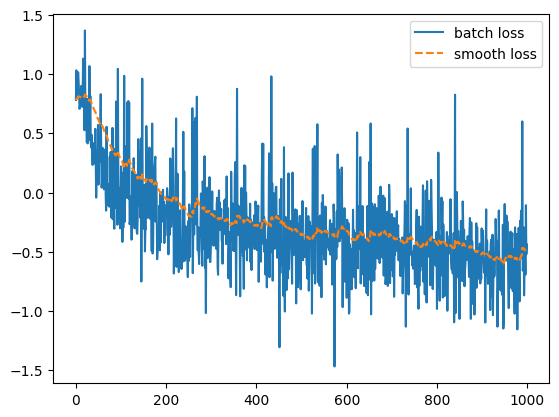

In [138]:
plt.plot(np.log(loss), label='batch loss')
beta = 0.97
ema = []
avg = loss[0]
for l in loss:
    avg = beta * avg + (1 - beta) * l
    ema.append(avg)
plt.plot(np.log(ema), '--', label='smooth loss')

plt.legend()

[tensor([[ 18524.5664,  -3934.9062, -20215.8789],
        [ 72818.5234,  78064.5312,  15990.0527],
        [  5942.9834,   8034.6289,  16868.9609],
        [ 15109.0469, -12889.0547, -36668.6719],
        [ -4835.9844, -48572.7031,  56357.1562],
        [-44493.6875,   4677.9155, -24702.7656],
        [-44591.5391, -26179.7578,  31752.8320],
        [ -2997.1992, -50943.6250, -13416.5957],
        [-10115.0547,  41370.1016, -23311.5742]]), tensor([7, 8, 7, 8, 6, 8, 7, 7, 7]), tensor([446320.6250,  69409.1641, 146524.8594, 499849.5000, 592265.7500,
        484633.8438, 588854.6250, 302829.6562, 345756.9062])]


(<Figure size 1000x800 with 1 Axes>, <Axes3D: title={'center': 'Molécule'}>)

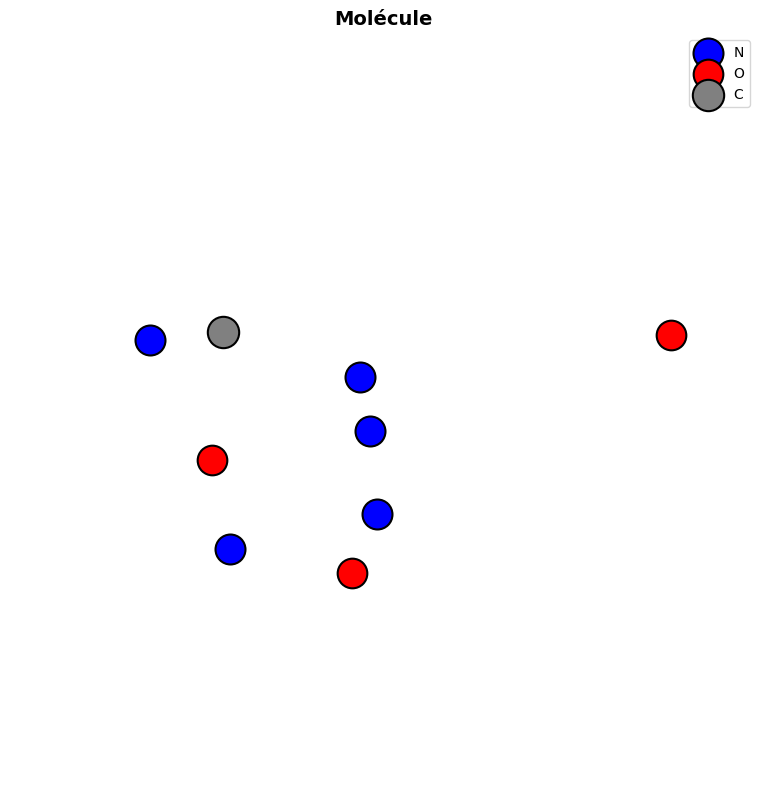

In [139]:
s = model.sample(1, 9)
mol = one_hot_decode([a[0] for a in s])
print(mol)
plot_molecule(mol_to_dict(mol))

In [175]:
with torch.no_grad():
    batch = one_hot_encode(next(batch_gen))
    x, e, q = batch
    B = x.shape[0]

    t = torch.randint(5, 5 + 1, (B, 1), device=device).float() # Random timestep per batch
    eps_x = torch.randn_like(x, device=device) # (B, N, 3)
    eps_e = torch.randn_like(e, device=device) # (B, N, D)
    eps_q = torch.randn_like(q, device=device) # (B, N)

    # Diffusion step: add noise to x0
    alpha_t = torch.tensor(model.alpha)[t.long()].view(B, 1, 1)
    omega_t = torch.sqrt(torch.tensor(model.omega))[t.long()].view(B, 1, 1)
    x_t = alpha_t * x + omega_t * eps_x
    e_t = alpha_t * e + omega_t * eps_e
    q_t = alpha_t.squeeze(-1) * q + omega_t.squeeze(-1) * eps_q

    # Predict denoised offset (model learns to predict ε)
    eps_x_pred, eps_e_pred, eps_q_pred = model.forward((x_t, e_t, q_t), t)
    print(eps_x_pred[0]-eps_x[0])

tensor([[-1.1802,  0.0835, -0.4008],
        [-0.3624,  0.0591, -0.0611],
        [-0.0640, -0.2194, -0.9211],
        [ 0.5618, -0.2695, -0.9018],
        [ 0.4162, -0.4533, -0.2435],
        [ 0.1294, -0.6383, -0.2600],
        [ 0.7418,  1.2580,  0.2723],
        [ 0.4349,  0.6983, -0.2727],
        [ 1.2629,  0.5637, -0.5720],
        [-0.2131,  0.5665, -0.3350],
        [-1.3773,  0.4386, -1.1850],
        [-1.2911,  0.8213, -0.2287],
        [ 0.7361,  0.2024, -0.8502],
        [-0.3354,  0.5611, -0.6685],
        [-0.2677, -0.1450, -1.5288],
        [ 1.0290, -0.1349, -1.1501],
        [ 0.4175, -0.1825, -0.5657],
        [-1.2800, -0.2702,  0.7170],
        [ 1.5395,  0.7550, -0.7361]])
